In [ ]:
# ==================================
# Experiment 4
# ==================================

# estimate the number of encountered polytopes when varying the neural
# network architecture / capacity. Again, classifier trained on random
# data in R^2

In [1]:
import numpy as np
from plnn import PLNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import utilities as utils
import matplotlib.pyplot as plt


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:

# ==================================
# Generate Training Points
# ==================================

print('===============Generating Training Points============')
# random points at least 2r apart
m = 12
np.random.seed(3)
x = [np.random.uniform(size=(2))]
r = 0.16
while(len(x) < m):
    p = np.random.uniform(size=(2))
    if min(np.abs(p-a).sum() for a in x) > 2*r:
        x.append(p)
# r = 0.145
epsilon = r/2

X = torch.Tensor(np.array(x))
torch.manual_seed(1)
y = (torch.rand(m)+0.5).long()



===============Generating Training Points============


===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=6, bias=True)
  (2): ReLU()
  (3): Linear(in_features=6, out_features=6, bias=True)
  (4): ReLU()
  (5): Linear(in_features=6, out_features=6, bias=True)
  (6): ReLU()
  (7): Linear(in_features=6, out_features=6, bias=True)
  (8): ReLU()
  (9): Linear(in_features=6, out_features=2, bias=True)
)
===============Training Network============
error:  tensor(0.2500)
===============Gathering Polytopes============


/home/justin/Programs/anaconda3/envs/DeepL/lib/python3.6/site-packages/torch/tensor.py:255: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


number of polytopes: 26
===============Initializing Network============
Sequential(
  (1): Linear(in_features=2, out_features=100, bias=True)
  (2): ReLU()
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Linear(in_features=100, out_features=100, bias=True)
  (6): ReLU()
  (7): Linear(in_features=100, out_features=100, bias=True)
  (8): ReLU()
  (9): Linear(in_features=100, out_features=2, bias=True)
)
===============Training Network============
error:  tensor(0.)
===============Gathering Polytopes============
number of polytopes: 4430


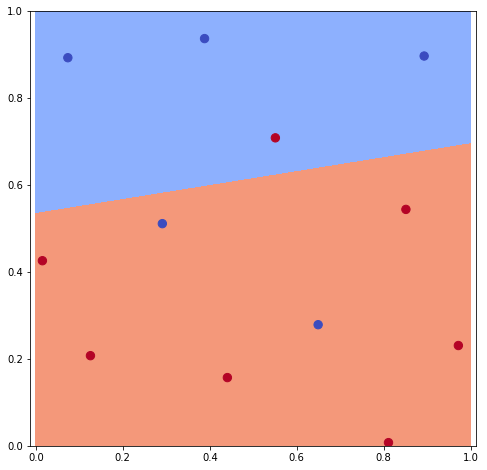

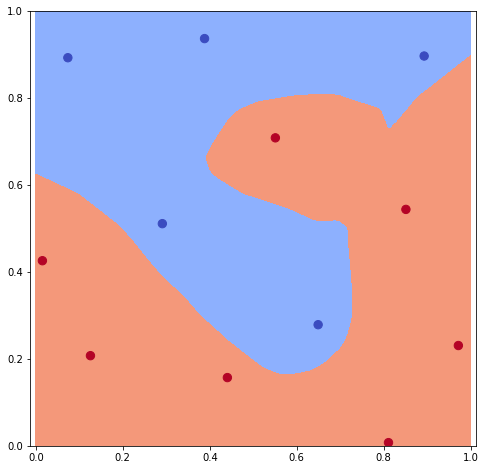

In [3]:
# ===========================================
# Estimate Polytope Density as Net Width Increases 
# ===========================================
widths = [int(elem) for elem in np.linspace(6, 100, 15)]
errs = []
unique_polytopes = []

for width in widths:
    layer_sizes = [2] + [width for _ in range(0, 4)] + [2]

    # ==================================
    # Initialize Network
    # ==================================
    
    print('===============Initializing Network============')
    network = PLNN(layer_sizes)
    net = network.net
    
    # ==================================
    # Train Network
    # ==================================
    
    print('===============Training Network============')
    opt = optim.Adam(net.parameters(), lr=1e-3)
    for i in range(1000):
        out = net(Variable(X))
        l = nn.CrossEntropyLoss()(out, Variable(y))
        err = (out.max(1)[1].data != y).float().mean()
        opt.zero_grad()
        (l).backward()
        opt.step()
    errs.append(err)
    print('error: ', err)
    
    # ==================================
    # Visualize: baseline classifier boundary
    # ==================================

    XX, YY = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
    X0 = Variable(torch.Tensor(np.stack([np.ravel(XX), np.ravel(YY)]).T))
    y0 = network(X0)
    ZZ = (y0[:,0] - y0[:,1]).resize(100, 100).data.numpy()

    _, ax = plt.subplots(figsize=(8,8))
    ax.contourf(XX,YY,-ZZ, cmap="coolwarm", levels=np.linspace(-1000,1000,3))
    ax.scatter(X.numpy()[:,0], X.numpy()[:,1], c=y.numpy(), cmap="coolwarm", s=70)
    ax.axis("equal")
    ax.axis([0, 1, 0, 1])
    
    # ==================================
    # Gather Polytopes
    # ==================================
    print('===============Gathering Polytopes============')
    num_pts = 350
    xylim = 1.0
    
    unique_relu_configs_list, unique_bin_acts, _, _ = utils.get_unique_relu_configs(network, xylim, num_pts)
    unique_polytopes.append(len(unique_bin_acts))
    print('number of polytopes:', len(unique_bin_acts))


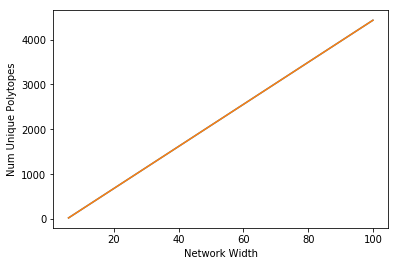

In [5]:
# ==================================
# Plot Results
# ==================================

xs = widths
ys = unique_polytopes

plt.figure()
plt.plot(xs,ys)
plt.plot(np.unique(xs), np.poly1d(np.polyfit(xs, ys, 1))(np.unique(xs)))
plt.xlabel('Network Width')
plt.ylabel('Num Unique Polytopes')

import os
cwd = os.getcwd()
plot_dir = cwd + '/plots/'
filename = plot_dir + 'width_experiment' + '.svg'
plt.savefig(filename)

In [ ]:
plt.plot(xs,errs[0:-1])